In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import requests
from bs4 import BeautifulSoup as bs
import zipfile
import io
import json
import matplotlib.dates as mdates

In [6]:
url = "https://webrobots.io/kickstarter-datasets/"
response = requests.get(url)
soup = bs(response.content, "html.parser")
csv_links = []

# Find links to CSV files
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.zip'):
        filename = href.split("/")[-1]
        date_str = filename.split("_")[1]
        if date_str >= "2020-12":
            csv_links.append(href)

# Download and process CSV files
dfs = []
for link in csv_links:
    # Download zip file from link
    response = requests.get(link)
    # Create a BytesIO object from the zip file content
    zip_file = io.BytesIO(response.content)
    # Extract CSV files from the zip archive and load them into pandas dataframes
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        for csv_file in csv_files:
            with zip_ref.open(csv_file) as file:
                df = pd.read_csv(file)
                df = df.rename(columns={'goal': 'goal_usd'})
                # Keep only the desired columns
                columns_to_keep = [ 'launched_at', 'backers_count','country','state', 'usd_pledged', 'category',
                                   'goal_usd']
                df = df[columns_to_keep]
                # Convert date columns to datetime
                df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')
                
                # Append dataframe to list
                dfs.append(df)

# Concatenate all dataframes into one
df_webrobot = pd.concat(dfs)


In [10]:


def get_category_name(json_str):
    data = json.loads(json_str)
    return data.get('parent_name','unknown')

df_webrobot['category'] = df_webrobot['category'].apply(get_category_name)



In [11]:
df_webrobot

,launched_at,backers_count,country,state,usd_pledged,category,goal_usd
0,2016-03-16 14:35:24,362,US,successful,88701.000000,Technology,75000.0
1,2016-03-15 17:05:02,125,US,successful,124293.000000,Technology,115000.0
2,2016-03-09 12:01:08,252,US,successful,76694.000000,Technology,50000.0
3,2016-03-08 12:26:58,22,CA,successful,1195.593020,Technology,400.0
4,2016-03-05 00:01:27,484,US,successful,21850.990000,Technology,15000.0
...,...,...,...,...,...,...,...
3145,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.0
3146,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & Video,30000.0
3147,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,350000.0
3148,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1000.0


In [62]:
df_kaggle =pd.read_csv('Kickstarter Campaigns DataSet.csv' , index_col=0)
df_kaggle = df_kaggle[['launched_at', 'backers_count', 'country','status', 'usd_pledged', 'sub_category', 'goal_usd']]
df_kaggle = df_kaggle.rename(columns={'status': 'state', 'sub_category': 'category'})
df_kaggle['category'] = df_kaggle['category'].str.capitalize()
df_kaggle

,launched_at,backers_count,country,state,usd_pledged,category,goal_usd
0,2018-02-10 22:47:52,16,CA,failed,577.902078,Food,785.82065
1,2014-11-21 10:42:26,7,US,successful,211.000000,Publishing,93.00000
2,2020-10-19 05:26:59,99,US,successful,4697.000000,Food,1500.00000
3,2019-05-29 16:01:34,3,US,failed,222.000000,Technology,25000.00000
4,2015-11-19 20:36:01,100,US,successful,5410.000000,Publishing,5000.00000
...,...,...,...,...,...,...,...
217248,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.00000
217249,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & video,40621.01400
217250,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,17662.55400
217251,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1354.03380


In [63]:
df = pd.concat([df_webrobot, df_kaggle], axis=0)
df['category'] = df['category'].str.lower().str.strip()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2349293 entries, 0 to 217252
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   launched_at    object 
 1   backers_count  int64  
 2   country        object 
 3   state          object 
 4   usd_pledged    float64
 5   category       object 
 6   goal_usd       float64
dtypes: float64(2), int64(1), object(4)
memory usage: 143.4+ MB


In [64]:
df.describe()
nRow, nCol = df.shape

print(f'There are {nRow} rows and {nCol} columns')

There are 2349293 rows and 7 columns


In [65]:
df.describe()

,backers_count,usd_pledged,goal_usd
count,2.349293e+06,2.347725e+06,2.349293e+06
mean,1.601275e+02,1.524074e+04,5.011768e+04
std,9.573008e+02,1.291944e+05,1.197591e+06
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.510000e+02,1.500000e+03
50%,3.100000e+01,1.851000e+03,5.000000e+03
75%,1.000000e+02,7.511000e+03,1.500000e+04
max,1.853410e+05,4.175415e+07,1.354034e+08


In [66]:
print("duplicates: ", df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

# original row-length was  1885897. check after removal of duplicates
print("length of dataset after removal of duplicates is ", len(df))

duplicates:  1885897
length of dataset after removal of duplicates is  463396


In [67]:
#Convert the 'launched_at' column to datetime format
df['launched_at'] = pd.to_datetime(df['launched_at'])
# Create a timestamp for January 1st, 2010
start_date = pd.Timestamp('2010-01-01')

# Filter the dataframe to only include rows where launched_at is after or equal to start_date
df = df[df['launched_at'] >= start_date]
year_count = df['launched_at'].dt.year.value_counts().sort_index()

c:\Users\ilyes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


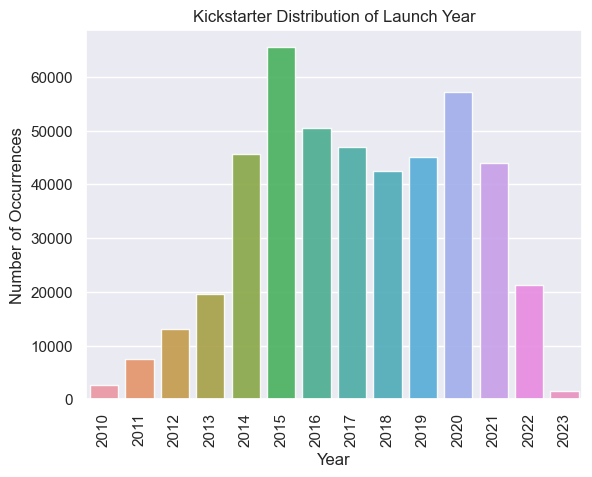

In [68]:
#distribution of launch year
sns.set(style="darkgrid")# Plot the
sns.barplot(year_count.index, year_count.values, alpha=0.9)
plt.title('Kickstarter Distribution of Launch Year')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=90, horizontalalignment="center")
plt.show()

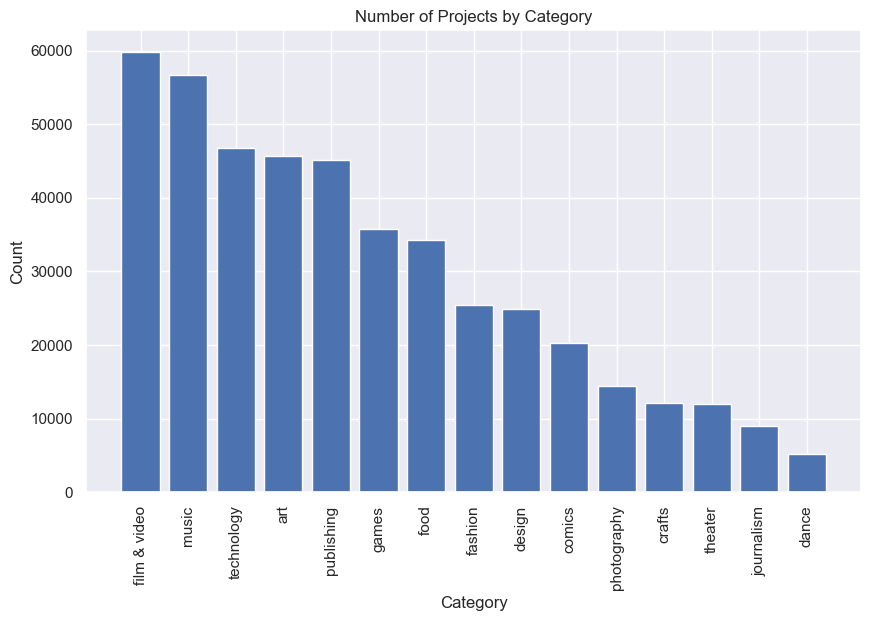

In [69]:
df.drop(df[df['category'] == 'unknown'].index, inplace=True)
# Get the count of projects by category
counts = df['category'].value_counts()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='b')

# Set the title, x-axis and y-axis labels
plt.title('Number of Projects by Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()


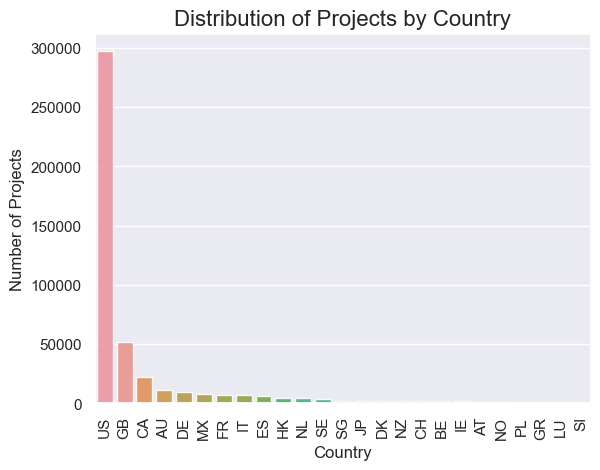

In [70]:
# Get the number of projects by country
projects_by_country = df['country'].value_counts()

# Plot the distribution of projects by country
sns.set(style="darkgrid")
sns.barplot(x=projects_by_country.index, y=projects_by_country.values, alpha=0.9)
plt.title('Distribution of Projects by Country', fontsize=16)
plt.ylabel('Number of Projects', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=90, horizontalalignment="center")
plt.show()


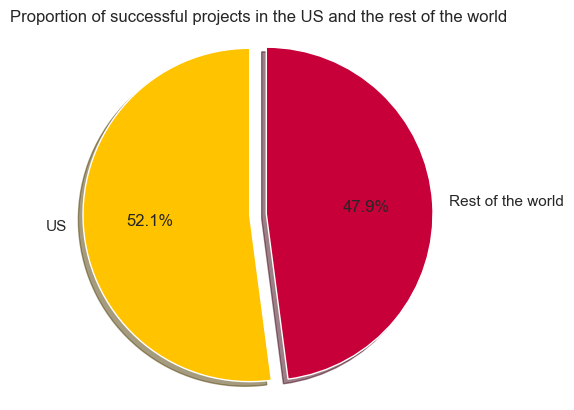

In [71]:
# Extract the number of successful projects in the US and the rest of the world
us_success = df[df['country'] == 'US']['state'].value_counts(normalize=True)['successful']
rest_success = df[df['country'] != 'US']['state'].value_counts(normalize=True)['successful']

# Create a pie chart
labels = ['US', 'Rest of the world']
sizes = [us_success, rest_success]
colors = sns.color_palette(['#FFC300', '#C70039'])
explode = (0.1, 0)  # explode the US slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Proportion of successful projects in the US and the rest of the world')

plt.show()


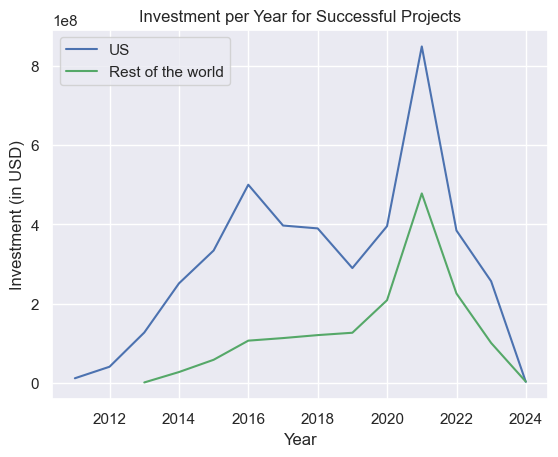

In [72]:
# Filter the DataFrame to include only successful projects in the US and the rest of the world
df_us_success = df[(df['country'] == 'US') & (df['state'] == 'successful')]
df_rest_success = df[(df['country'] != 'US') & (df['state'] == 'successful')]

# Group the filtered DataFrames by year and aggregate the investment values
df_us_yearly = df_us_success.groupby(pd.Grouper(key='launched_at', freq='Y'))['usd_pledged'].sum()
df_rest_yearly = df_rest_success.groupby(pd.Grouper(key='launched_at', freq='Y'))['usd_pledged'].sum()

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the investment per year for US successful projects
ax.plot_date(df_us_yearly.index, df_us_yearly.values, fmt='-', color='b', label='US')

# Plot the investment per year for successful projects in the rest of the world
ax.plot_date(df_rest_yearly.index, df_rest_yearly.values, fmt='-', color='g', label='Rest of the world')

# Format the x-axis to show only the year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set the x-axis label
ax.set_xlabel('Year')

# Set the y-axis label
ax.set_ylabel('Investment (in USD)')

# Set the title
ax.set_title('Investment per Year for Successful Projects')

# Show the legend
ax.legend()

# Show the plot
plt.show()


In [73]:
us_df = df[df['country'] == 'US']
status_counts = us_df['state'].value_counts(normalize=True)*100
status_counts


successful    53.608421
failed        35.691290
live           6.404430
canceled       4.295523
suspended      0.000336
Name: state, dtype: float64

In [74]:
us_df = df[df['country'] == 'US']
us_status_counts = us_df['state'].value_counts()
us_failed_count = us_status_counts['failed']

In [75]:
us_failed_projects = us_df[us_df['state'] == 'failed']
failed_by_category = us_failed_projects.groupby('category')['state'].count().sort_values(ascending=False)
print(failed_by_category)


category
food            15431
film & video    14963
technology      13150
music           12755
art             11423
publishing       7883
crafts           5281
photography      4564
fashion          4333
games            4255
journalism       3706
design           3495
theater          2542
comics           1341
dance             975
Name: state, dtype: int64


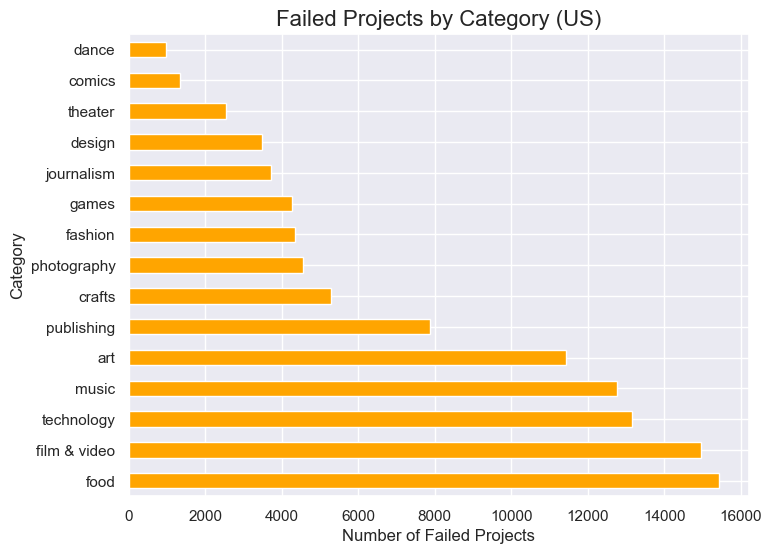

In [76]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
failed_by_category.plot(kind='barh', color='orange', ax=ax)

# Set the chart title and labels
ax.set_title('Failed Projects by Category (US)', fontsize=16)
ax.set_xlabel('Number of Failed Projects', fontsize=12)
ax.set_ylabel('Category', fontsize=12)

# Show the plot
plt.show()